# DEEP LEARNING’S Bi-LSTM (Bidirectional Long Short-Term Memory) ALGORITHM FOR DETECTING KEYLOGGERS.


#### AIM: To test BI-LSTM Algorithm for classification of keyloggers.

#### IMPORT REQUIRED LIBRARIES

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.utils import class_weight
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

from google.colab import files
from google.cloud import storage
from google.colab import auth

from tensorflow.keras import Model, Sequential, Input,  backend
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

%matplotlib inline

#### Reading Data

In [ ]:
files.upload() # Upload kaggle json key

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mickyangelo","key":"de08ff490082dfb6430401b58a924b1d"}'}

In [ ]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d subhajournal/keylogger-detection # downloading dataset

 82% 65.0M/79.4M [00:00<00:00, 102MB/s] 
100% 79.4M/79.4M [00:00<00:00, 90.9MB/s]


In [ ]:
# Unzip data in Google Colab

!unzip -q /content/keylogger-detection.zip -d dataset

In [ ]:
base_skin_dir = "/content/dataset"

data1 = pd.read_csv(os.path.join(base_skin_dir, 'Keylogger_Detection.csv')) # load in the data
data1.head(5)

<ipython-input-8-20af472914e2>:5: DtypeWarning: Columns (48,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv(os.path.join(base_skin_dir, 'Keylogger_Detection.csv')) # load in the data


,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,0,10.42.0.211-52.6.25.230-34451-443-6,10.42.0.211,34451.0,52.6.25.230,443.0,6.0,04/08/2017 05:12:36,12140931.0,9.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,1,172.217.3.99-10.42.0.151-443-53892-6,10.42.0.151,53892.0,172.217.3.99,443.0,6.0,04/08/2017 07:55:51,418882.0,102.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,2,172.217.3.98-10.42.0.151-443-50750-6,172.217.3.98,443.0,10.42.0.151,50750.0,6.0,04/08/2017 08:48:19,45.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,3,10.42.0.211-10.42.0.1-23025-53-17,10.42.0.211,23025.0,10.42.0.1,53.0,17.0,04/08/2017 05:54:10,541699.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,4,10.42.0.211-123.129.244.226-52602-443-6,10.42.0.211,52602.0,123.129.244.226,443.0,6.0,04/08/2017 08:44:25,7310795.0,3.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


#### Understanding Data

In [ ]:
data1.columns # checking columns in dataset

Index(['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Len

In [ ]:
data1.info() # checking general data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523617 entries, 0 to 523616
Data columns (total 86 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    523617 non-null  int64  
 1   Flow ID                       523610 non-null  object 
 2    Source IP                    523617 non-null  object 
 3    Source Port                  523617 non-null  float64
 4    Destination IP               523617 non-null  object 
 5    Destination Port             523617 non-null  float64
 6    Protocol                     523617 non-null  float64
 7    Timestamp                    523617 non-null  object 
 8    Flow Duration                523617 non-null  float64
 9    Total Fwd Packets            523617 non-null  float64
 10   Total Backward Packets       523617 non-null  float64
 11  Total Length of Fwd Packets   523617 non-null  float64
 12   Total Length of Bwd Packets  523617 non-nul

In [ ]:
data1.describe() # checking general statistical information about dataset

,Unnamed: 0,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,523617.000000,523617.000000,523617.000000,523617.000000,5.236170e+05,523617.000000,523617.000000,5.236170e+05,5.236170e+05,523617.000000,...,523597.000000,5.235970e+05,5.235970e+05,5.235950e+05,5.235950e+05,5.235950e+05,5.235950e+05,5.235950e+05,5.235950e+05,5.235950e+05
mean,261808.000000,38389.622917,6222.747054,8.435195,1.116307e+07,9.475619,17.819533,1.043487e+03,2.156387e+04,215.842782,...,1.777533,-2.135277e+04,1.659947e+05,2.369898e+04,1.887055e+05,1.482351e+05,4.390550e+06,4.059862e+05,4.738970e+06,4.082014e+06
std,151155.352289,18713.642457,15681.211329,157.569965,2.307145e+07,97.897284,321.858169,5.361425e+04,4.633844e+05,369.316080,...,37.463590,5.169081e+06,9.027506e+05,3.757831e+05,1.078287e+06,8.526430e+05,1.511112e+07,3.337708e+06,1.598408e+07,1.470351e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,-1.395062e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,130904.000000,34019.000000,80.000000,6.000000,3.730600e+04,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,261808.000000,43186.000000,443.000000,6.000000,4.745050e+05,2.000000,1.000000,3.100000e+01,0.000000e+00,31.000000,...,0.000000,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,392712.000000,52281.000000,443.000000,6.000000,1.031474e+07,6.000000,4.000000,4.620000e+02,4.140000e+02,350.000000,...,1.000000,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,523616.000000,124560.000000,65428.000000,65812.000000,1.199967e+08,8671.000000,14993.000000,1.249095e+07,2.166097e+07,1460.000000,...,8669.000000,1.705248e+08,5.041965e+07,5.795123e+07,9.139736e+07,4.993167e+07,1.196749e+08,7.554958e+07,1.196749e+08,1.196749e+08


In [ ]:
data1.dtypes # checking data types per column

Unnamed: 0           int64
Flow ID             object
 Source IP          object
 Source Port       float64
 Destination IP     object
                    ...   
Idle Mean          float64
 Idle Std          float64
 Idle Max          float64
 Idle Min          float64
Class               object
Length: 86, dtype: object

In [ ]:
data1.shape # checking data size

(523617, 86)

In [ ]:
Class_df = data1["Class"]
data2_df = data1.select_dtypes(include=[np.number])
data2_df = data2_df.join(Class_df)

In [ ]:
data2 = pd.DataFrame(data2_df)
data2.head(2)

,Unnamed: 0,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,0,34451.0,443.0,6.0,12140931.0,9.0,6.0,334.0,3664.0,208.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,1,53892.0,443.0,6.0,418882.0,102.0,203.0,829.0,279509.0,517.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


#### Data Preparation

In [ ]:
# Drop unwanted columns

data2.drop('Unnamed: 0', axis=1, inplace=True)
data2.head(2)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,34451.0,443.0,6.0,12140931.0,9.0,6.0,334.0,3664.0,208.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,53892.0,443.0,6.0,418882.0,102.0,203.0,829.0,279509.0,517.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [ ]:
# Removing nan values

print(data2.isna().sum().sum())

879


In [ ]:
data2 = data2.dropna() # drop nan values since nan is very small

**Split Data to Train & Validation**

In [ ]:
train_data, val_data = train_test_split(data2, test_size=0.01, random_state=42) # give 1% of data for final validation and ue 99% for training and evaluation

In [ ]:
# convert each set to csv

train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('validation_data.csv', index=False)

In [ ]:
train_data.shape, val_data.shape # checking each data size

((518359, 79), (5236, 79))

In [ ]:
train_df = pd.read_csv('train_data.csv') # read training dataset to work with

In [ ]:
# convert categorical target class to numerical repreentation

train_df.loc[train_df.Class == "Benign", 'Class'] = 0
train_df.loc[train_df.Class == "Keylogger", 'Class'] = 1

train_df.head(5)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,53654.0,80.0,6.0,19999.0,1.0,1.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,18751.0,53.0,17.0,51814.0,1.0,1.0,38.0,90.0,38.0,38.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,46124.0,443.0,6.0,85941144.0,15.0,17.0,1291.0,10418.0,953.0,0.0,...,20.0,953315.0,0.0,953315.0,953315.0,84987777.0,0.0,84987777.0,84987777.0,0
3,41345.0,80.0,6.0,613942.0,3.0,7.0,474.0,5949.0,474.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,42880.0,443.0,6.0,296687.0,9.0,8.0,906.0,3607.0,514.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


#### Distribution Classes

In [ ]:
train_df.groupby('Class').size() # checking target distribution

Class
0    305704
1    212655
dtype: int64

#### Check Data Distribution

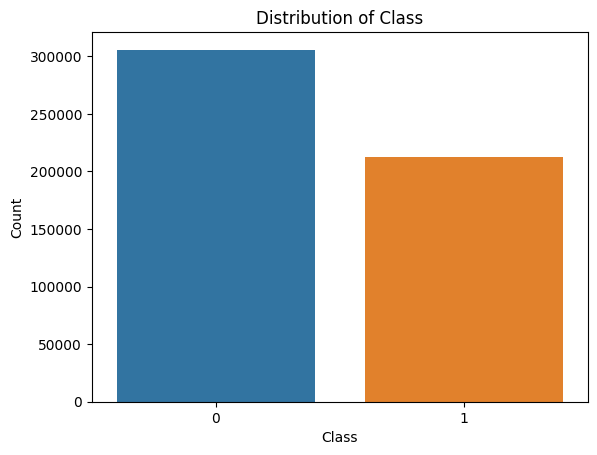

In [ ]:
# plot target distribution

sns.countplot(data=train_df, x='Class')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Class')
plt.show()

OBSERVATION: Keylogger class (1) is underrepresented. Data is highly imbalanced.

**Uplample Imbalanced Dataset Using Scikit Resample Technique**

In [ ]:
# To Upsample Target

#create two dataframes for majority and minorit class
data_maj = train_df[(train_df['Class'] == 0)]
data_min = train_df[(train_df['Class'] == 1)]

#upsample minority class
data_up = resample(data_min, replace = True, n_samples = 305700, random_state = 42)

#combine upsampled class and majority class
train_df = pd.concat([data_up, data_maj])

#### Remove Useless Features

In [ ]:
for col in (train_df.iloc[:, :-1].columns):
    if(train_df[col].min() == train_df[col].max()):
            train_df.drop(col, axis = 1, inplace = True)

In [ ]:
train_df.shape

(611404, 68)

In [ ]:
# copy dataframe

data3 = train_df.copy()
data3.head(2)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
297540,51218.0,443.0,6.0,62172.0,2.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
358042,48563.0,443.0,6.0,59.0,1.0,1.0,31.0,0.0,31.0,31.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


#### Split DataSet.

In [ ]:
target = ['Class']
features = [c for c in data3.columns if c != "Class"]

In [ ]:
X = data3[features].values # Features
y = data3[target].values # Target

X = X.astype(np.float32)
y = y.astype(np.float32)

X.shape, y.shape,

((611404, 67), (611404, 1))

In [ ]:
data3.groupby('Class').size()

Class
0    305704
1    305700
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y) # split the initial 99% dataset into train and test  to build model with

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((489123, 67), (122281, 67), (489123, 1), (122281, 1))

#### Build Model

In [ ]:
# Scale features and target

scaler = MinMaxScaler()
le = LabelEncoder()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


print(X_train.shape)
print(X_test.shape)
labels_dict = dict(zip(le.classes_, range(len(le.classes_))))
print(labels_dict)

(489123, 67)
(122281, 67)
{0.0: 0, 1.0: 1}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
# transform ndarray into dataframe type for later operation.

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [ ]:
X_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,0.544619,0.001223,0.352941,4.166781e-08,0.000115,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.891079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.759522,0.006771,0.352941,2.500068e-07,0.000000,0.000067,0.000002,0.0,0.021233,0.021233,...,0.0,0.891079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.767137,0.001223,0.352941,2.025313e-01,0.000115,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.891079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_test.head(3)

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,0.682552,0.006771,1.000000,2.545374e-02,0.000807,0.000534,0.000203,0.000119,0.924658,0.023973,...,0.000807,0.891079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.557438,0.006771,0.352941,3.579264e-05,0.000115,0.000000,0.000002,0.000000,0.021233,0.000000,...,0.000000,0.891079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.006760,0.760317,0.352941,2.666740e-07,0.000115,0.000000,0.000004,0.000000,0.037671,0.000000,...,0.000000,0.891079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# getting best features using F-ANOVA technique
# Compute the ANOVA F-value
f_value = f_classif(X_train, y_train)

# Now we select the top 20 important features based on the result above.

sel_top_cols = SelectKBest(f_classif, k=20)
sel_top_cols.fit(X_train, y_train)
X_train.columns[sel_top_cols.get_support()]

# transform ndarray back:
X_train = X_train.values
X_test = X_test.values

In [ ]:
# reshape input data to LSTM format [samples, time_steps, features]

X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(f"shape of X_train:", X_train_lstm.shape)
print(f"shape of X_test:", X_test_lstm.shape)

shape of X_train: (489123, 1, 67)
shape of X_test: (122281, 1, 67)


**Model Architecture**

In [ ]:
n_classes = 1
print(f"num of classes: {n_classes}")
n_features = X_train_lstm.shape[2]

def MultiClassModelImproved(n_features, n_classes=1):
    model = Sequential()
    model.add(Input(shape=(None, n_features)))
    model.add(Bidirectional(LSTM(units=1024, return_sequences=True, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.01))
    model.add(Bidirectional(LSTM(units=768, return_sequences=True, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.01))
    model.add(Bidirectional(LSTM(units=512, return_sequences=True, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.01))
    model.add(Bidirectional(LSTM(units=256, return_sequences=True, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.01))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.01))
    model.add(Bidirectional(LSTM(units=64, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.01))
    model.add(Dense(n_classes, activation="sigmoid", name="output"))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

num of classes: 1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, None, 2048)       8945664   
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, None, 2048)       8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, None, 2048)        0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 1536)       17307648  
 nal)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, None, 1536)       6144      
 hNormalization)                                        

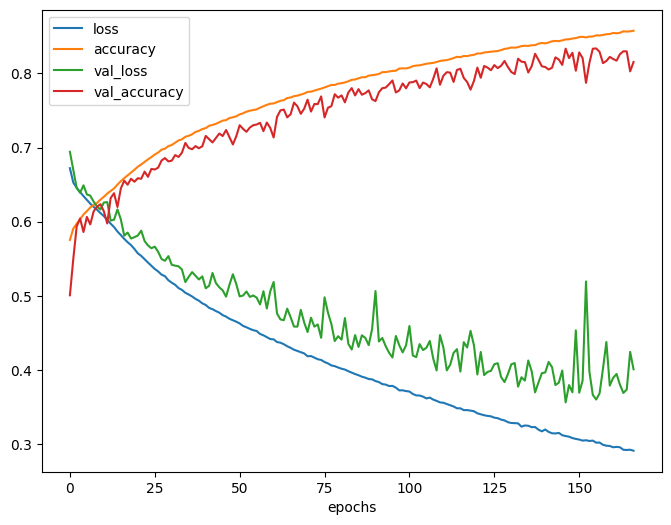

In [ ]:
# Early stopping callback
callback = EarlyStopping(patience=20, mode='min', restore_best_weights=True)

# Clear the session to reset any existing models
backend.clear_session()

# Create the improved model
improved_model = MultiClassModelImproved(n_features, n_classes)

# Calculate class weights
class_weights = {0: 1, 1: len(y_train[y_train==0])/len(y_train[y_train==1])}


# Train the model with class weights
history = improved_model.fit(X_train_lstm, y_train,
                             epochs=200, batch_size=1024,
                             validation_split=0.2, callbacks=[callback],
                             class_weight=class_weights)

# Check the loss trend of epochs
pd.DataFrame(history.history).plot(kind='line', xlabel='epochs', figsize=(8, 6))
plt.show()

**Model Evaluation**

In [ ]:
# predicting on training set

y_train_pred_prob = improved_model.predict(X_train_lstm)
y_test_pred_prob = improved_model.predict(X_test_lstm)

3822/3822 [==============================] - 24s 6ms/step


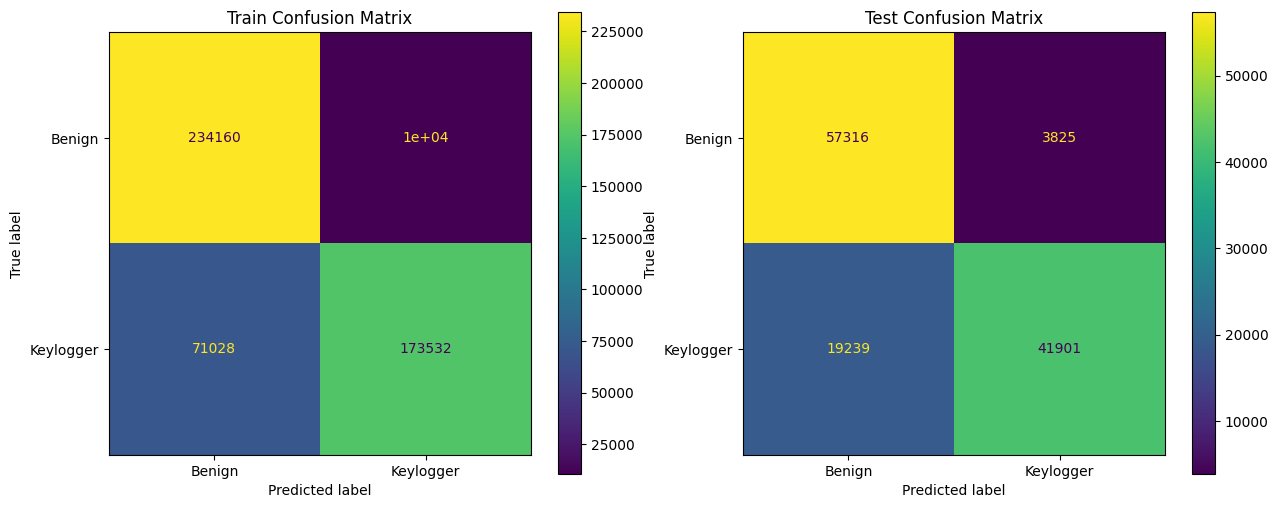

In [ ]:
# Convert predicted probabilities to binary predictions
y_train_pred = (y_train_pred_prob > 0.7).astype(int)
y_test_pred = (y_test_pred_prob > 0.7).astype(int)

# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Display confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=["Benign", "Keylogger"]).plot(ax=ax[0])
ax[0].set_title("Train Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Benign", "Keylogger"]).plot(ax=ax[1])
ax[1].set_title("Test Confusion Matrix")

plt.show()

In [ ]:
# helper function for classification report

def multilabel_matrix(y_true, y_pred, labels=None):
    mlm = multilabel_confusion_matrix(y_true, y_pred, labels=labels)
    df_performance = pd.DataFrame(index=labels, columns=['accuracy', 'precision', 'recall', 'f1_score'])
    for i, label in enumerate(labels):
        tn, fp, fn, tp = mlm[i].ravel()
        accuracy = (tn + tp) / (tn + fp + fn + tp)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        f1_score = 2*precision * recall / (precision + recall)
        df_performance.loc[label] = [round(accuracy, 4), round(precision,4), \
                                     round(recall, 4), round(f1_score,4)]
    return df_performance

In [ ]:
# checking training classification report

y_train_pred_labels = le.inverse_transform(y_train_pred)
y_train_labels = le.inverse_transform(y_train)
print(classification_report(y_train_labels, y_train_pred_labels))
performance = multilabel_matrix(y_train_pred_labels, y_train_labels, labels=le.classes_)
performance

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         0.0       0.77      0.96      0.85    244563
         1.0       0.94      0.71      0.81    244560

    accuracy                           0.83    489123
   macro avg       0.86      0.83      0.83    489123
weighted avg       0.86      0.83      0.83    489123



,accuracy,precision,recall,f1_score
0.0,0.8335,0.9575,0.7673,0.8519
1.0,0.8335,0.7096,0.9434,0.81


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_0, *['precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_1, *['recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_2, *['f1_score'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_3, *['precision', 'recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_4, *['recall', 'f1_score'], **{})
chart

In [ ]:
# checking testing classification report

y_test_pred_labels = le.inverse_transform(y_test_pred)
y_test_true_labels = le.inverse_transform(y_test)
print(classification_report(y_test_true_labels,y_test_pred_labels))

performance = multilabel_matrix(y_test_true_labels, y_test_pred_labels, labels=le.classes_)
performance

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         0.0       0.75      0.94      0.83     61141
         1.0       0.92      0.69      0.78     61140

    accuracy                           0.81    122281
   macro avg       0.83      0.81      0.81    122281
weighted avg       0.83      0.81      0.81    122281



,accuracy,precision,recall,f1_score
0.0,0.8114,0.7487,0.9374,0.8325
1.0,0.8114,0.9163,0.6853,0.7842


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(performance, *['precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(performance, *['recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(performance, *['f1_score'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(performance, *['precision', 'recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(performance, *['recall', 'f1_score'], **{})
chart

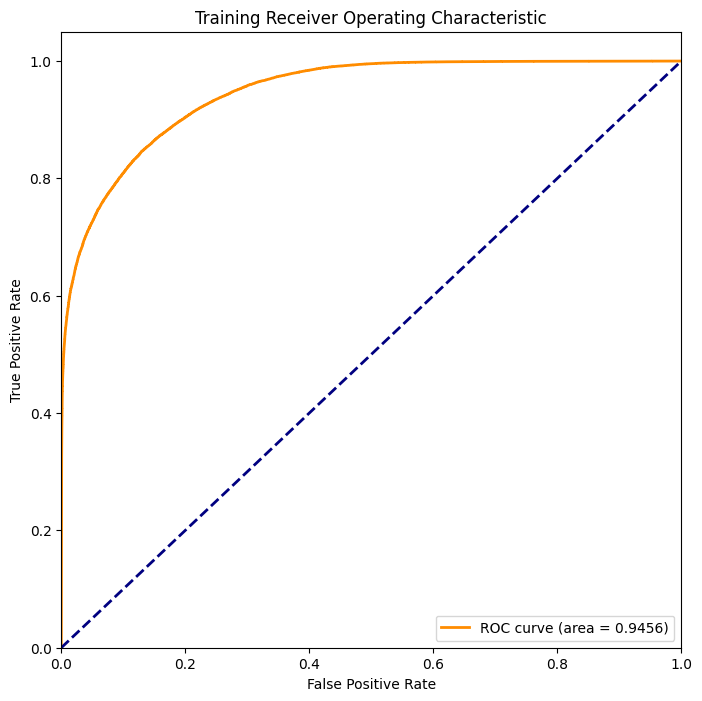

In [ ]:
# checking training ROC curve
# Calculate ROC curve and AUC

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_prob)
roc_auc = roc_auc_score(y_train, y_train_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


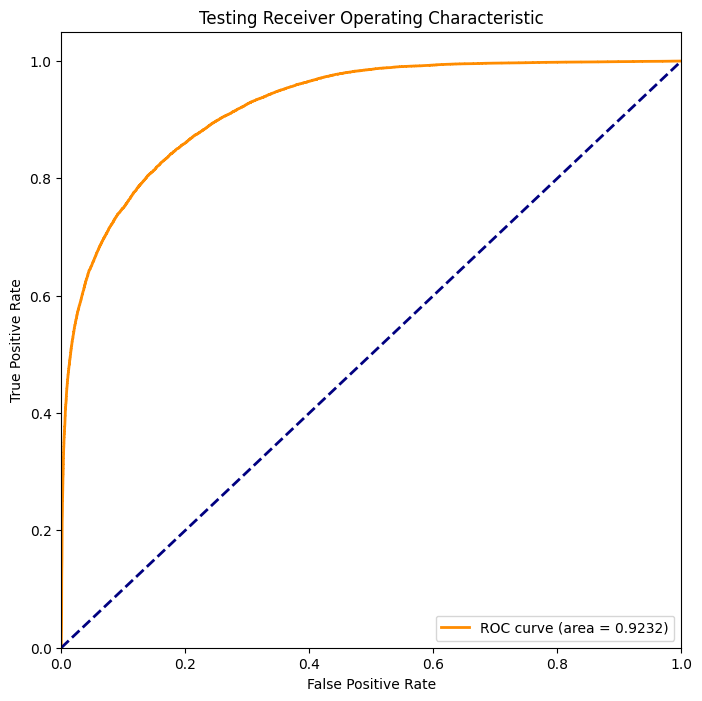

In [ ]:
# checking testing ROC curve
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Testing Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

**Save & Push Best Model to GCP Bucket**

In [ ]:
# Save model architecture and weights
improved_model.save('bi_lstm_model.h5')

In [ ]:
# Authenticating colab with GCP

auth.authenticate_user()

In [ ]:
!pip install google-cloud-storage

In [ ]:
# Pushing saved model to GCP Bucket
# Initialize the storage client
client = storage.Client()

# Replace 'your-bucket-name' with the name of your GCS bucket
bucket_name = 'bi_lstm_model'
model_local_path = '/content/bi_lstm_model.h5'

# Get the bucket
bucket = client.bucket(bucket_name)

# Upload the model file to the bucket
model_blob = bucket.blob('model.h5')  # Specify the path within the bucket
model_blob.upload_from_filename(model_local_path)


**Testing Saved Model Using Initial 1% Dataset**

In [ ]:
# Load the model
loaded_model = load_model('bi_lstm_model.h5')

# Assuming you have a new data (X_new) for which you want to make predictions
X_new = pd.read_csv('/content/validation_data.csv')
X_new.head(5)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,60523.0,80.0,6.0,3565260.0,5.0,3.0,1306.0,193.0,1306.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,55399.0,443.0,6.0,117721188.0,9.0,8.0,1311.0,1073.0,902.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,37848.0,80.0,6.0,3877193.0,2.0,0.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Keylogger
3,35349.0,443.0,6.0,11643161.0,2.0,0.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Keylogger
4,52497.0,443.0,6.0,78266502.0,15.0,14.0,8772.0,1129.0,1368.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [ ]:
# Drop target from dataset
X_new.drop('Class', axis = 1, inplace = True)

X_new.head(5)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,60523.0,80.0,6.0,3565260.0,5.0,3.0,1306.0,193.0,1306.0,0.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55399.0,443.0,6.0,117721188.0,9.0,8.0,1311.0,1073.0,902.0,0.0,...,3.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,37848.0,80.0,6.0,3877193.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35349.0,443.0,6.0,11643161.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,52497.0,443.0,6.0,78266502.0,15.0,14.0,8772.0,1129.0,1368.0,0.0,...,9.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Dropping usesless features

for col in (X_new.iloc[:, :-1].columns):
    if(X_new[col].min() == X_new[col].max()):
            X_new.drop(col, axis = 1, inplace = True)

In [ ]:
# Scale dataset
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_new)

print(X_new.shape)

(5236, 67)


In [ ]:
# transform ndarray into dataframe type for later operation

X_trans = pd.DataFrame(X_scaled)
X_trans

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,0.924778,0.001317,0.352941,2.971493e-02,0.000992,0.000203,0.012945,0.000009,0.894521,0.000000,...,0.003096,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.846484,0.007293,0.352941,9.811568e-01,0.001984,0.000540,0.012995,0.000050,0.617808,0.000000,...,0.009288,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.578309,0.001317,0.352941,3.231476e-02,0.000248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.540125,0.007293,0.352941,9.704086e-02,0.000248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.802142,0.007293,0.352941,6.523185e-01,0.003472,0.000946,0.086950,0.000053,0.936986,0.000000,...,0.027864,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231,0.800018,0.001317,0.352941,3.155425e-01,0.000496,0.000068,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5232,0.770207,0.007293,0.352941,2.500374e-07,0.000000,0.000068,0.000307,0.000000,0.021233,0.021233,...,0.000000,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5233,0.818507,0.001317,0.352941,4.741385e-03,0.000744,0.000203,0.003955,0.000026,0.273288,0.000000,...,0.003096,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5234,0.841014,0.001317,0.352941,5.281922e-01,0.000248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# reshape input data to LSTM format [samples, time_steps, features]

X_new_lstm = X_trans.values.reshape(X_trans.shape[0], 1, X_trans.shape[1])

print(f"shape of X_train:", X_new_lstm.shape)

shape of X_train: (5236, 1, 67)


In [ ]:
# Make predictions using the loaded model
predictions = loaded_model.predict(X_new_lstm)

# Convert predicted probabilities to binary predictions using a threshold
threshold = 0.5  # Adjust this threshold as needed
binary_predictions = (predictions > threshold).astype(int)

164/164 [==============================] - 3s 6ms/step


In [ ]:
binary_predictions.shape

(5236, 1)

In [ ]:
# Create a DataFrame with predictions
predictions_df = pd.DataFrame(binary_predictions, columns=["Predictions"])
predictions_df.head(5)

,Predictions
0,0
1,0
2,0
3,0
4,0


In [ ]:
# Convert X_new_lstm to a DataFrame
# Create a DataFrame with reshaped data and column names

X_new_lstm_df = pd.DataFrame(X_new_lstm[:, 0, :], columns=X_new.columns)
X_new_lstm_df.head(5)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.924778,0.001317,0.352941,0.029715,0.000992,0.000203,0.012945,0.000009,0.894521,0.0,...,0.003096,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.846484,0.007293,0.352941,0.981157,0.001984,0.000540,0.012995,0.000050,0.617808,0.0,...,0.009288,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.578309,0.001317,0.352941,0.032315,0.000248,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.540125,0.007293,0.352941,0.097041,0.000248,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.802142,0.007293,0.352941,0.652319,0.003472,0.000946,0.086950,0.000053,0.936986,0.0,...,0.027864,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Concatenate the predictions DataFrame with X_new_lstm
X_new_with_predictions = pd.concat([X_new_lstm_df, predictions_df], axis=1)

X_new_with_predictions.head(10)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Predictions
0,0.924778,0.001317,0.352941,0.029715,0.000992,0.000203,0.012945,0.000009,0.894521,0.000000,...,0.344262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0.846484,0.007293,0.352941,0.981157,0.001984,0.000540,0.012995,0.000050,0.617808,0.000000,...,0.540984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,0.578309,0.001317,0.352941,0.032315,0.000248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.344262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,0.540125,0.007293,0.352941,0.097041,0.000248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.344262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,0.802142,0.007293,0.352941,0.652319,0.003472,0.000946,0.086950,0.000053,0.936986,0.000000,...,0.540984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
5,0.254744,0.000872,1.000000,0.011573,0.000000,0.000068,0.000317,0.000016,0.021918,0.021918,...,0.737705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6,0.788314,0.001317,0.352941,0.044342,0.000248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.344262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
7,0.006769,0.994567,0.352941,0.591629,0.005952,0.001959,0.009000,0.000031,0.172603,0.000000,...,0.540984,0.064573,0.200158,0.189741,0.016392,0.113626,0.072334,0.157344,0.061497,0
8,0.548208,0.000872,1.000000,0.000515,0.000000,0.000068,0.000317,0.000004,0.021918,0.021918,...,0.540984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
9,0.569003,0.007293,0.352941,0.001272,0.000744,0.000405,0.026119,0.000040,0.936986,0.000000,...,0.540984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
